In [2]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [105]:
matplotlib.rcParams.update({'font.size': 14})

In [104]:
%matplotlib notebook

In [6]:
pd.__version__
sns.__version__

'1.1.3'

'0.11.0'

### Load Data

In [179]:
from typing import List, Dict, NamedTuple
import datetime


def pg_array2datetime_list(pg_array_string: str,
                           datetime_format: str = '%Y-%m-%d %H:%M:%S.%f') -> List[datetime.datetime]:
    return [datetime.datetime.strptime(d, datetime_format) 
            for d in pg_array_string.strip('{}').split(',')]

In [8]:
df = pd.read_csv('../data/endorsement_histories.csv',
                converters={'event_ts':pg_array2datetime_list})

In [37]:
df.count()

account_number    23489
policy_number     23489
event_history     23489
event_ts          23489
dtype: int64

In [9]:
df.head(2)

account_number            policy_number event_history  \
0          316716  AJGALL0001HIBP-39862-01         bgigg   
1         1222758  COVCW00007HIBP-01287-01            bg   

                                            event_ts  
0  [2020-03-04 18:22:04.757000, 2020-03-05 16:43:...  
1  [2017-10-04 15:54:07.496000, 2018-05-15 19:11:...

### Calc distributions of endorsement events

In [178]:
import re
from collections import defaultdict, namedtuple

def find_all_match_group_positions(pattern:str , string:str) -> Dict[str,List]:
    '''
    Uses re.finditer() to return all match groups and corresponding
    start positions of a regex pattern in a string.
    
    Args:
        pattern (str): regex pattern
        string (str)
    
    Returns:
        match_positions (defaultdict(list)): keys are match groups & 
            values are group start positions (list(int))
    '''
    match_positions = defaultdict(list)
    [match_positions[m.group()].append(m.start()) for m in re.finditer(pattern, string)]
    return match_positions

In [199]:
def extract_match_group_timestamps(match_group: str, ts_list: List[datetime.datetime]) -> List[datetime.datetime]:
    '''
    Use this to parse results of find_all_match_group_positions.

    For supplied match_group (i.e. event sequence), use corresponding 
    match start positions as indices of datetime list to find start datetime of event sequence.
    
    Args:
        match_group (str)
        ts_list (list(datetime))
    
    Returns:
        list(datetime): start timestamps of match_group

    '''
    return [ts_list[ind] for ind in matches.get(match_group)] if matches.get(match_group) else None

In [198]:
def timedelta2days(timedelta: datetime.timedelta, tolerance=0) -> int:
        '''Convert time delta to days by rounding total seconds of duration'''
        return round(timedelta.total_seconds()/86400, tolerance)

In [13]:
endorsement_diffs = defaultdict(list)

for row in df.itertuples(index=False):
    matches = (find_all_match_pos('[abg]', row.event_history))
    
    endorsement_dates = get_timestamps('g')
    new_biz_date = get_timestamps('b')
    renewal_date = get_timestamps('a')
    
    if new_biz_date and renewal_date:
        raise Exception('New biz and renewal occured for the same policy!')
    if new_biz_date:
        if not len(new_biz_date) == 1:
            print(f"{row.account_number}: {row.event_history}")
        else:
            nbd = new_biz_date[0]
            ym = nbd.strftime('%Y-%m')
            key = '_'.join([ym, 'new_biz'])
            date_diffs = [timedelta2days(e - new_biz_date[0]) for e in endorsement_dates]
            endorsement_diffs[key].extend(date_diffs)
    elif renewal_date:
        if not len(renewal_date) == 1:
            print(f"{row.account_number}: {row.event_history}")
        else:
            rd = renewal_date[0]
            ym = rd.strftime('%Y-%m')
            key = '_'.join([ym, 'renewal'])
            date_diffs = [timedelta2days(e - renewal_date[0]) for e in endorsement_dates]
            endorsement_diffs[key].extend(date_diffs)

7730405408: iacgac


In [14]:
[(k, len(v)) for k,v in endorsement_diffs.items()][:5]

[('2020-03_new_biz', 1079),
 ('2017-10_new_biz', 220),
 ('2019-09_new_biz', 1323),
 ('2019-07_new_biz', 1356),
 ('2020-06_renewal', 348)]

### Check for anomalous endorsements before policy start

In [329]:
import numpy as np

nb = np.array(endorsement_diffs['new_biz'])
nb[nb<0]
r = np.array(endorsement_diffs['renewal'])
r[r<0]

array([], dtype=float64)

### Histogram & Visualize

In [15]:
#Get data into df for plotting
rdf = pd.DataFrame(endorsement_diffs.items(), columns=('key','data'))

In [16]:
rdf['month'] = rdf.key.map(lambda x: x.split('_')[0])
rdf['year'] = rdf.month.map(lambda x: x.split('_')[0].split('-')[0])
rdf['event'] = rdf.key.map(lambda x: x[8:])
rdf.drop('key', axis=1, inplace=True)

In [17]:
rdf = rdf.explode('data')

In [18]:
rdf.head()

data    month  year    event
0    1  2020-03  2020  new_biz
0  101  2020-03  2020  new_biz
0  151  2020-03  2020  new_biz
0   86  2020-03  2020  new_biz
0    7  2020-03  2020  new_biz

In [35]:
df_filter = (~rdf.year.isin(['2016','2017'])) & (rdf.data<=90)
g = sns.displot(rdf[df_filter],
            x="data", hue="year", col='event',
            kind="ecdf",
#             binwidth=30,
#             multiple='dodge',
#             stat='probability',
#             cumulative=True,
#             common_norm=False
#             height=2,
#             aspect=1,
#             hue_order=np.sort(rdf.year.unique())
           )
for ax in g.axes.squeeze():
    ax.set_xticks(np.arange(0,100, 10));
    ax.xaxis.set_tick_params(rotation=15);
    ax.set_xbound(lower=-1, upper=90);
    ax.set_xlabel('Days After Event');
    ax.set_ylabel('Fraction Endorsements');

<IPython.core.display.Javascript object>

Text(0.5, 9.444444444444438, 'Days After Event')

Text(13.016319444444457, 0.5, 'Fraction Endorsements')

Text(0.5, 9.444444444444438, 'Days After Event')

Text(530.251704635965, 0.5, 'Fraction Endorsements')

In [36]:
df_filter = (~rdf.year.isin(['2016','2017','2018'])) & (rdf.data<=90)
g = sns.displot(rdf[df_filter],
            x="data", hue="event", row='year',
            kind="ecdf",
#             binwidth=30,
#             multiple='dodge',
#             stat='probability',
#             cumulative=True,
#             common_norm=False
#             height=2,
#             aspect=1,
#             hue_order=np.sort(rdf.year.unique())
           )
for ax in g.axes.squeeze():
    ax.set_xticks(np.arange(0,91, 10));
    ax.xaxis.set_tick_params(rotation=15);
    ax.set_xbound(lower=-1, upper=90);
    ax.set_xlabel('Days After Event');
    ax.set_ylabel('Fraction Endorsements');

<IPython.core.display.Javascript object>

Text(0.5, 516.5555555555555, 'Days After Event')

Text(18.352083333333326, 0.5, 'Fraction Endorsements')

Text(0.5, 9.444444444444324, 'Days After Event')

Text(18.352083333333326, 0.5, 'Fraction Endorsements')

### Distributions grouped by attributes

In [40]:
adf = pd.read_csv('../data/endorsements_atts_dist.csv')

In [41]:
adf

ts_endorsement  year  is_sse  \
0      2020-03-05 16:43:41.825000  2020    True   
1      2020-06-13 19:42:36.444000  2020   False   
2      2020-08-02 18:12:35.295000  2020   False   
3      2018-05-15 19:11:37.209000  2018   False   
4      2019-09-17 18:05:17.121000  2019   False   
...                           ...   ...     ...   
37721  2019-01-31 14:02:01.049000  2019   False   
37722  2020-01-15 01:46:14.043000  2020   False   
37723  2020-04-01 21:51:22.266000  2020   False   
37724  2018-10-22 20:25:26.966000  2018   False   
37725  2018-12-28 15:03:40.147000  2018   False   

                            broker_segment                 first_event  \
0                             Large Retail  policy_action_new_business   
1                             Large Retail  policy_action_new_business   
2                             Large Retail  policy_action_new_business   
3                                  Digital  policy_action_new_business   
4      Small Retail Agency Network (child)  policy_action_new_business   
...                                    ...                         ...   
37721                            Wholesale  policy_action_new_business   
37722                  Small Retail Direct  policy_action_new_business   
37723                  Small Retail Direct  policy_action_new_business   
37724                            Wholesale  policy_action_new_business   
37725                            Wholesale  policy_action_new_business   

             days  
0        0.931679  
1      101.055922  
2      150.993409  
3      223.137149  
4        4.495537  
...           ...  
37721    0.703040  
37722   53.239717  
37723   70.225279  
37724    3.211044  
37725   69.987586  

[37726 rows x 6 columns]

In [141]:
# g.legend.update(loc='upper right')
# g.legend.update({'bbo':'upper right'})

#### new biz

In [160]:
horder = np.flip(np.sort(adf.broker_segment.fillna('NA').unique())).tolist()

<IPython.core.display.Javascript object>


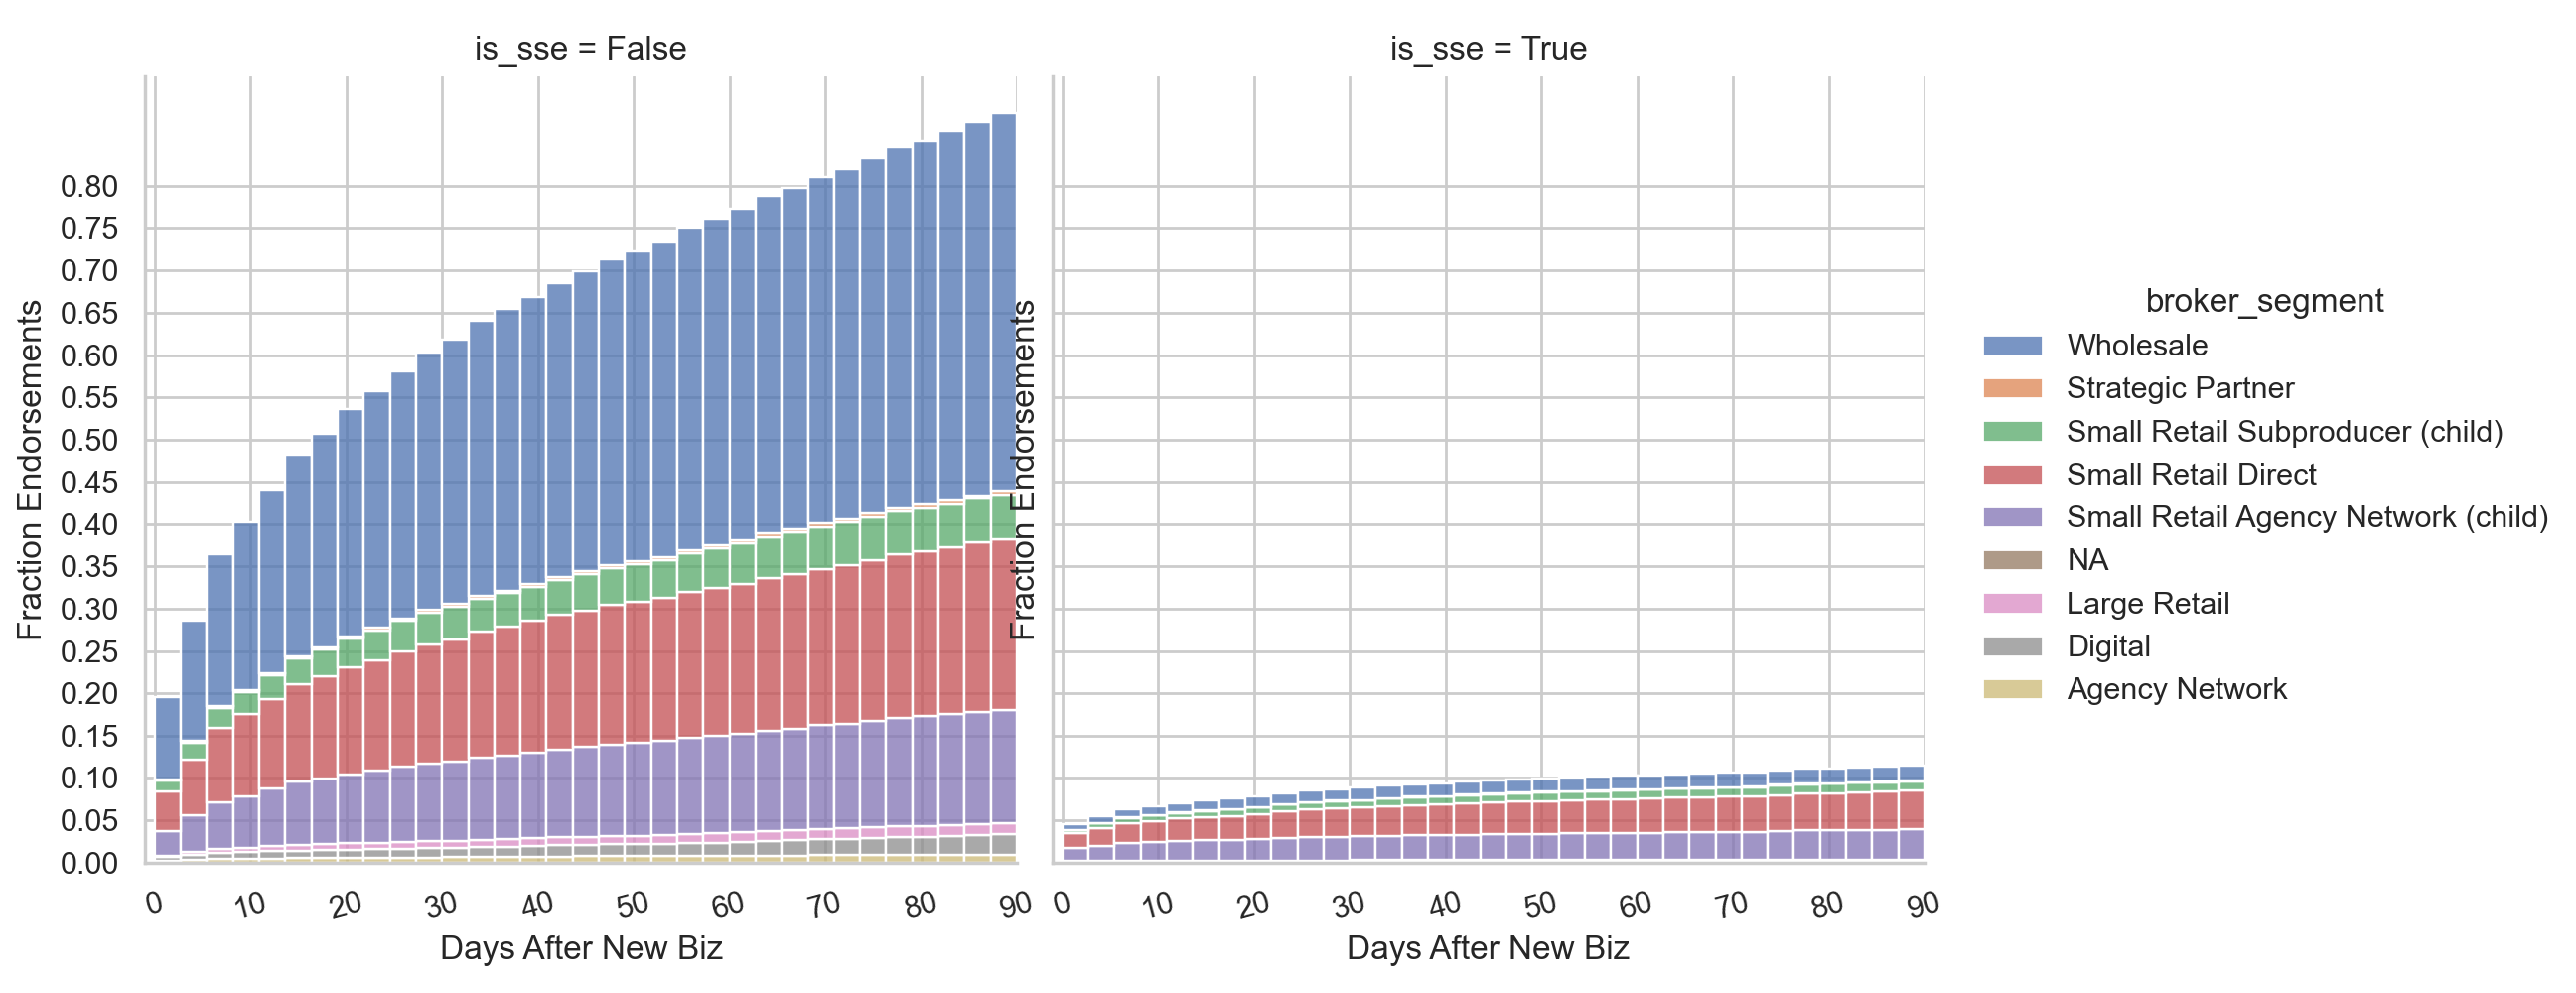

Text(0.5, 12.44444444444443, 'Days After New Biz')

Text(28.02044444444445, 0.5, 'Fraction Endorsements')

Text(0.5, 12.44444444444443, 'Days After New Biz')

Text(541.5963538180958, 0.5, 'Fraction Endorsements')

In [164]:
sns.set_theme(style="whitegrid")
df_filter = (~adf.year.isin(['2016','2017'])) & (adf.days<=90) & (adf.first_event=='policy_action_new_business')

g = sns.displot(
    data=adf[df_filter],
    x="days", hue="broker_segment", 
    col='is_sse',
    stat = 'probability',
    multiple="stack",
    hue_order=horder,
#     edgecolor=".3",
#     linewidth=.5,
#     common_norm = True,
    cumulative=True,
#     legend=False,
#     facet_kws={"legend_out": False}
)

for ax in g.axes.squeeze():
    ax.set_xticks(np.arange(0,91, 10));
    ax.set_yticks(np.arange(0,.81, .05));
    ax.xaxis.set_tick_params(rotation=15);
    ax.set_xbound(lower=-1, upper=90);
    ax.set_xlabel('Days After New Biz');
    ax.set_ylabel('Fraction Endorsements');

# g.legend.update({'draggable':True})
# plt.legend(loc='upper right')
# ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([500, 1000, 2000, 5000, 10000])

#### renewals

In [166]:
sns.set_theme(style="whitegrid")
df_filter = (~adf.year.isin(['2016', '2017'])) & (adf.days <= 90) & (
    adf.first_event == 'policy_action_renewal')

g = sns.displot(
    data=adf[df_filter],
    x="days", hue="broker_segment",
    col='is_sse',
    stat='probability',
    multiple="stack",
    hue_order=horder,
    #     edgecolor=".3",
    #     linewidth=.5,
    #     common_norm = True,
    cumulative=True,
    legend=False,
    #     facet_kws={"legend_out": False}
)

for ax in g.axes.squeeze():
    ax.set_xticks(np.arange(0, 91, 10))
    ax.set_yticks(np.arange(0, .81, .05))
    ax.xaxis.set_tick_params(rotation=15)
    ax.set_xbound(lower=-1, upper=90)
    ax.set_xlabel('Days After Renewal')
    ax.set_ylabel('Fraction Endorsements')

# g.legend.update({'draggable':True})
# plt.legend(loc='upper right')
# ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([500, 1000, 2000, 5000, 10000])

<IPython.core.display.Javascript object>

Text(0.5, 12.44444444444443, 'Days After Renewal')

Text(12.444444444444445, 0.5, 'Fraction Endorsements')

Text(0.5, 12.44444444444443, 'Days After Renewal')

Text(525.9791666666666, 0.5, 'Fraction Endorsements')

### Delinquency exit time distribution

#### Load event history CSV

In [439]:
ddf = pd.read_csv('../data/sms_delinq_start_exit.csv',
                converters={'event_ts':pg_array2datetime_list})

In [440]:
ddf.head(2)

account_number             policy_number event_history  \
0        10129441  REGRIG00001HIBP-47091-01            se   
1        21749452    UNTC00001HIBP-19149-01             e   

                                     event_ts  \
0  [2020-10-03 00:00:00, 2020-10-06 19:58:46]   
1                       [2020-10-16 19:04:01]   

                     broker_segment base_state  sms_subscribed  
0  Small Retail Subproducer (child)      Texas           False  
1               Small Retail Direct   New York           False

#### Find start-exit event strings and calc durations

In [444]:
se_diffs = defaultdict(list)
BrokerAtts = namedtuple('BrokerAtts', ['broker_segment', 'base_state', 'sms_subscribed'])

for row in ddf.itertuples(index=False):
    #get timestamp of start delinquency
    se_inds = find_all_match_group_positions('se', row.event_history)['se']
    # if SE event found
    if se_inds:
        for start_ind in se_inds:
            #calc start-exit duration
            start_ts = row.event_ts[start_ind]
            exit_ts = row.event_ts[start_ind+1]
            date_diff = timedelta2days(exit_ts - start_ts, tolerance=1)
            #construct groupby keys
            key =  BrokerAtts(**dict([(k, row._asdict()[k]) for k in BrokerAtts._fields]))
            se_diffs[key].append(date_diff)

#### Process results

In [445]:
rdf = pd.DataFrame(se_diffs.items(), columns=('key','data'))

In [446]:
for field in BrokerAtts._fields:
    rdf[field] = rdf['key'].map(lambda x: x._asdict()[field])
rdf.head()

key  \
0   (Small Retail Subproducer (child), Texas, False)   
1  (Small Retail Agency Network (child), North Ca...   
2             (Small Retail Direct, Illinois, False)   
3                        (Wholesale, Florida, False)   
4  (Small Retail Subproducer (child), New York, F...   

                                                data  \
0  [3.8, 2.9, 3.7, 3.8, 7.9, 22.3, 3.6, 20.1, 1.6...   
1          [3.1, 5.8, 6.8, 2.6, 6.8, 3.2, 5.9, 18.9]   
2        [24.3, 8.8, 18.9, 4.8, 3.8, 4.7, 16.9, 9.0]   
3  [6.6, 1.5, 1.7, 3.7, 1.5, 6.8, 3.7, 2.1, 1.7, ...   
4  [1.5, 1.8, 3.7, 10.5, 1.8, 10.9, 1.8, 15.8, 3....   

                        broker_segment      base_state  sms_subscribed  
0     Small Retail Subproducer (child)           Texas           False  
1  Small Retail Agency Network (child)  North Carolina           False  
2                  Small Retail Direct        Illinois           False  
3                            Wholesale         Florida           False  
4     Small Retail Subproducer (child)        New York           False

Num events per SMS group

In [447]:
rdf.explode('data').groupby('sms_subscribed').count()

key  data  broker_segment  base_state
sms_subscribed                                       
False           863   863             861         863
True            111   111             111         111

Exit Time distribution

In [448]:
sns.set_theme(style="darkgrid")
#darkgrid, whitegrid, dark, white, and ticks
# df_filter = (~rdf.year.isin(['2016','2017'])) & (rdf.data<=90)
_, ax = plt.subplots()
sns.ecdfplot(rdf.explode('data'), x="data"
             , hue="sms_subscribed"  
#              , col='event'
#              , kind="ecdf"
#              binwidth=30,
#              multiple='dodge',
#              stat='probability',
#              cumulative=True,
#              common_norm=False
#              height=2,
#              aspect=1,
#              hue_order=np.sort(rdf.year.unique())
             , ax=ax
             )

ax.set_title('Delinquency Enter to Exit Time ')
ax.set_xlabel('Days')
ax.set_ylabel('Fraction of Enter-Exit Events')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Delinquency Enter to Exit Time ')

Text(0.5, 0, 'Days')

Text(0, 0.5, 'Fraction of Enter-Exit Events')

Correlations of sms vs non-sms group

In [425]:
gb = exploded.groupby(['broker_segment', 'base_state', 'sms_subscribed'])[
    'data'].count().reset_index()

In [436]:
gb[gb.sms_subscribed].sort_values('data', ascending=False).head(10)

broker_segment  base_state  sms_subscribed  data
63                   Small Retail Direct    New York            True    16
38   Small Retail Agency Network (child)       Texas            True    12
19   Small Retail Agency Network (child)     Florida            True     9
102                            Wholesale    New York            True     7
30   Small Retail Agency Network (child)    New York            True     7
70                   Small Retail Direct       Texas            True     6
78      Small Retail Subproducer (child)    New York            True     5
92                             Wholesale     Florida            True     5
16   Small Retail Agency Network (child)  California            True     3
45                   Small Retail Direct  California            True     3

In [437]:
gb[~gb.sms_subscribed].sort_values('data', ascending=False).head(10)

broker_segment base_state  sms_subscribed  data
62                   Small Retail Direct   New York           False   131
101                            Wholesale   New York           False    78
18   Small Retail Agency Network (child)    Florida           False    52
48                   Small Retail Direct    Florida           False    51
91                             Wholesale    Florida           False    50
29   Small Retail Agency Network (child)   New York           False    48
37   Small Retail Agency Network (child)      Texas           False    40
69                   Small Retail Direct      Texas           False    38
109                            Wholesale      Texas           False    31
72      Small Retail Subproducer (child)    Florida           False    31